In [4]:
%load_ext autoreload

# Set autoreload to update modules automatically before executing code
%autoreload 2
from envs.cartpole import Cartpole
from controllers.constant import target
from controllers.QP import QP_CBF_controller
from filters.disc import disc
from inv_set.cartpole import trap
from filters.NN_filters import FCN
from inv_set.inv_ped import cbf
import numpy as np
import matplotlib.pyplot as plt
import torch 
inv_set = trap(0.5, -5)
disc_steps = 2
env = Cartpole(inv_set, disc_steps)
input_size = 4
output_size = 2
n_layers = 5
size=1000
activation = 'relu'
lr = 5e-4
sc = 1
gamma_pos = 1
gamma_neg = 5
nn_filter = FCN(input_size, output_size, n_layers, size, activation, lr, sc, gamma_pos, gamma_neg)
checkpoint = torch.load('exps/cartpole/model.pth', map_location=torch.device('cpu'))
nn_filter.FCN.load_state_dict(checkpoint['model_state_dict'])
nn_filter.FCN.eval()

/home/artur/miniconda3/envs/fsrl/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Sequential(
  (0): Linear(in_features=4, out_features=1000, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1000, out_features=1000, bias=True)
  (3): ReLU()
  (4): Linear(in_features=1000, out_features=1000, bias=True)
  (5): ReLU()
  (6): Linear(in_features=1000, out_features=1000, bias=True)
  (7): ReLU()
  (8): Linear(in_features=1000, out_features=1000, bias=True)
  (9): ReLU()
  (10): Linear(in_features=1000, out_features=2, bias=True)
  (11): Identity()
)

In [13]:
nn_filter.forward([0,0,0.4,0])

(tensor([[-0.0022]], grad_fn=<SliceBackward0>),
 tensor([-0.0068], grad_fn=<SelectBackward0>))

In [5]:

from torch.distributions.uniform import Uniform
import random
def actor(state):
    nn_filter.FCN.eval()
    a_h,b_h = nn_filter.forward(state)
    a = Uniform(-1, 1).sample().unsqueeze(dim=0)
    if a_h @ a < b_h:
        a = a - (((a_h @ a) - b_h) / torch.norm(a, dim=-1)) * a_h
    return a, a_h, b_h


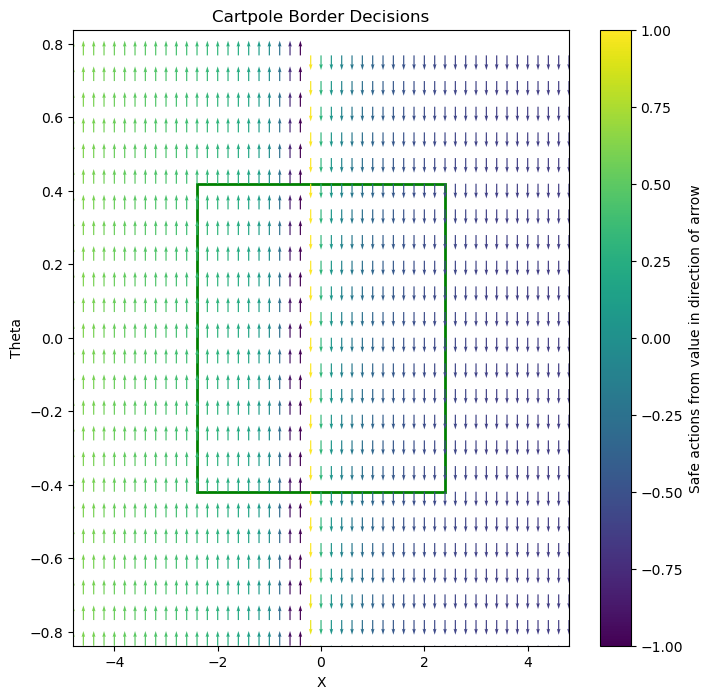

In [10]:
#Plot the hyperplanes in safe direction for all states
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
safe_radians = 24 * 2 * math.pi / 360
borders = []
arrowDirX=[]
arrowDirY=[]
safe_x=2.4
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
colors = []
for x in np.arange(-2.4-2.4,2.5+2.4,0.2):
    for theta in np.arange(-safe_radians*2,safe_radians*2,math.pi / 360 *8):
        o=[x,1,theta,1]
        a, a_h, b_h = actor(o)
        borders.append([x,theta])
        a_h = a_h.detach().numpy()
        b_h = b_h.detach().numpy()
        threshold = np.clip((b_h/a_h),-1,1)
        if(a_h>0):
            to_right_is_dangerous = False
        else:
            to_right_is_dangerous = True
        if to_right_is_dangerous:
            arrowDirX.append(0)
            arrowDirY.append(-1)
            colors.append(threshold)
        else:
            arrowDirX.append(0)
            arrowDirY.append(1)
            colors.append(threshold)
borders = np.array(borders)
rectangle = patches.Rectangle((-safe_x, -safe_radians), 2*safe_x, 2*safe_radians, linewidth=2, edgecolor='green', facecolor='white')
ax.add_patch(rectangle)
quiver_plot=plt.quiver(borders[:,0], borders[:,1], arrowDirX, arrowDirY,colors, cmap ="viridis", angles='xy', scale_units='xy', scale=25)
# This are the borders of the simulation
plt.axis([-2*safe_x, 2*safe_x, -2*safe_radians, 2*safe_radians])
plt.colorbar(quiver_plot, label="Safe actions from value in direction of arrow")            
plt.xlabel("X")
plt.ylabel("Theta")
plt.title("Cartpole Border Decisions")
plt.show()

-3.5999999999999996
-0.6283185307179586
[-0.30103]
[-3.6         0.         -0.62831853  0.        ]
-3.5999999999999996
-0.4886921905584123
[-0.20621598]
[-3.6         0.         -0.48869219  0.        ]
-3.5999999999999996
-0.34906585039886595
[-0.10489512]
[-3.6         0.         -0.34906585  0.        ]
-3.5999999999999996
-0.20943951023931962
[-0.2943798]
[-3.6         0.         -0.20943951  0.        ]
-3.5999999999999996
-0.06981317007977328
[0.26679286]
[-3.6         0.         -0.06981317  0.        ]
-3.5999999999999996
0.06981317007977306
[0.93975985]
[-3.6         0.          0.06981317  0.        ]
-3.5999999999999996
0.2094395102393194
[0.06113088]
[-3.6         0.          0.20943951  0.        ]
-3.5999999999999996
0.34906585039886573
[0.12686507]
[-3.6         0.          0.34906585  0.        ]
-3.5999999999999996
0.48869219055841207
[0.05223665]
[-3.6         0.          0.48869219  0.        ]
-3.1999999999999997
-0.6283185307179586
[0.8486582]
[-3.2         0.   

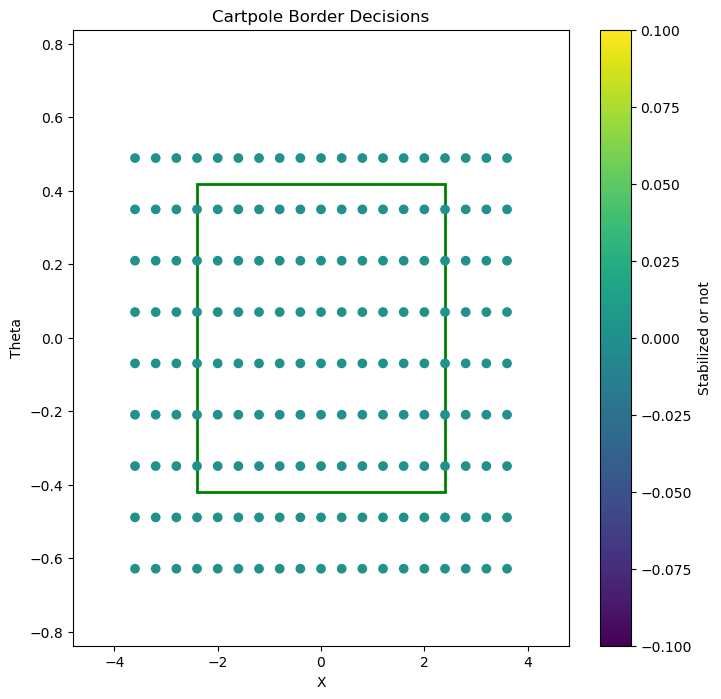

In [58]:
import time
import numpy as np
borders=[]
colors=[]
for x in np.arange(-2.4-1.2,2.5+1.2,0.4):
    for theta in np.arange(-safe_radians*1.5,safe_radians*1.5,math.pi / 360 *16):
        print(x)
        print(theta)
        o = env.reset([x,0,theta,0])
        steps = 0
        done = False
        while not done and steps <=1000:
            a, a_h, b_h = actor(o)
            a_h = a_h.detach().numpy()
            b_h = b_h.detach().numpy()
            a = a.detach().numpy().reshape(-1)
            threshold = np.clip((b_h/a_h)[0],-1,1)
            next_o, r, d, info = env.step(a)
            done = d
            steps +=1
            print(a)
            print(o)
            o = next_o
        borders.append([x,theta])
        if done: 
            colors.append(0)
        else:
            colors.append(1)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
borders = np.array(borders)
safe_x = 2.4
safe_radians = 24 * 2 * math.pi / 360
rectangle = patches.Rectangle((-safe_x, -safe_radians), 2*safe_x, 2*safe_radians, linewidth=2, edgecolor='green', facecolor='white')
ax.add_patch(rectangle)
scatter_plot=plt.scatter(borders[:,0], borders[:,1],c= colors, cmap="viridis")
# This are the borders of the simulation
plt.axis([-2*safe_x, 2*safe_x, -2*safe_radians, 2*safe_radians])
plt.colorbar(scatter_plot, label="Stabilized or not")            
plt.xlabel("X")
plt.ylabel("Theta")
plt.title("Cartpole Border Decisions")
plt.show()  # Close plot to avoid replotting issues

In [36]:
training_data = np.load("exps/cartpole/training_data.npz")
val_data = np.load("exps/cartpole/validation_data.npz")
train_states = training_data["train_states"]
train_inputs = training_data["train_inputs"]
train_labels = training_data["train_labels"]
val_states = val_data["val_states"]
val_inputs = val_data["val_inputs"]
val_labels = val_data["val_labels"]
#train_labels.shape
#train_states[train_labels==-1,:]

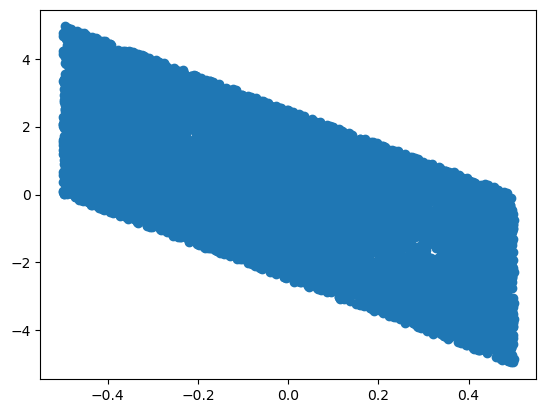

In [44]:
plt.scatter(train_states[:, 0], train_states[:, 1])
plt.show()

In [38]:
#train network with saved data
input_size = 4
output_size = 2
n_layers = 5
size=1000
activation = 'relu'
lr = 5e-4
sc = 1
gamma_pos = 1
gamma_neg = 5
model = FCN(input_size, output_size, n_layers, size, activation, lr, sc, gamma_pos, gamma_neg)
model.FCN.train()

# train network
num_states = 10000
num_inputs = 300
epochs = 10
num_log = 4

train_losses = []
val_losses = []
best_loss = float('inf')
for epoch in range(epochs):
    for i in range(5):
        train_loss = model.update2(train_states, train_inputs, train_labels, env)
    model.scheduler.step()
    if epoch % 1 == 0:
        train_losses.append(train_loss)
        val_loss = model.get_val_loss(val_states, val_inputs, val_labels, env)
        val_losses.append(val_loss)
        if val_loss < best_loss:
            torch.save({
            'model_state_dict': model.FCN.state_dict(),
            'optimizer_state_dict': model.optimizer.state_dict(),
            }, 'exps/cartpole/model.pth')
        train_losses = train_losses[-500:]
        val_losses = val_losses[-500:]
        print("epoch:", epoch, 'train loss:', train_loss)
        print("epoch:", epoch, 'val loss:', val_loss)

model.FCN.eval()

epoch: 0 train loss: 0.010476896910846255
epoch: 0 val loss: 0.010530997901456847
epoch: 1 train loss: 0.0018065053822701152
epoch: 1 val loss: 0.0027163885724669134
epoch: 2 train loss: 0.0006292553370480798
epoch: 2 val loss: 0.0013090783629555879
epoch: 3 train loss: 0.0007178743012669103
epoch: 3 val loss: 0.0008672426307625555
epoch: 4 train loss: 0.0004588935019345939
epoch: 4 val loss: 0.00046524318304236176
epoch: 5 train loss: 0.0003628425395938308
epoch: 5 val loss: 0.00019796201779770573
epoch: 6 train loss: 0.00022011250401172324
epoch: 6 val loss: 0.00016604032927301928
epoch: 7 train loss: 0.00011699759381280895
epoch: 7 val loss: 0.0001167229961156056
epoch: 8 train loss: 0.00011259646687137659
epoch: 8 val loss: 0.0001071357302274224
epoch: 9 train loss: 8.952877718619137e-05
epoch: 9 val loss: 5.0175987223971544e-05


Sequential(
  (0): Linear(in_features=4, out_features=1000, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1000, out_features=1000, bias=True)
  (3): ReLU()
  (4): Linear(in_features=1000, out_features=1000, bias=True)
  (5): ReLU()
  (6): Linear(in_features=1000, out_features=1000, bias=True)
  (7): ReLU()
  (8): Linear(in_features=1000, out_features=1000, bias=True)
  (9): ReLU()
  (10): Linear(in_features=1000, out_features=2, bias=True)
  (11): Identity()
)

In [41]:
from torch.distributions.uniform import Uniform
import random
def actor2(state):
    model.FCN.eval()
    a_h,b_h = model.forward(state)
    a = Uniform(-1, 1).sample().unsqueeze(dim=0)
    if a_h @ a < b_h:
        a = a - (((a_h @ a) - b_h) / torch.norm(a, dim=-1)) * a_h
    return a, a_h, b_h

In [51]:
from torch.distributions.uniform import Uniform
import random
import cvxpy as cp
def actor3(state):    
    state = np.array(state)
    a,b = model.get_hyp(state)
    a_norm = np.linalg.norm(a)
    a = a.astype(np.float64)
    b = b.astype(np.float64)
    a /= a_norm
    b /= a_norm
    target_u = Uniform(-1, 1).sample().unsqueeze(dim=0)
    P = np.eye((1))
    u = cp.Variable((1))
    eps = 1 #?????
    prob = cp.Problem(cp.Minimize((1/2)*cp.quad_form(u-target_u, P)),
                      [a@u >= b + eps]
                    )
    prob.solve()
    r = u.value
    return r, a, b

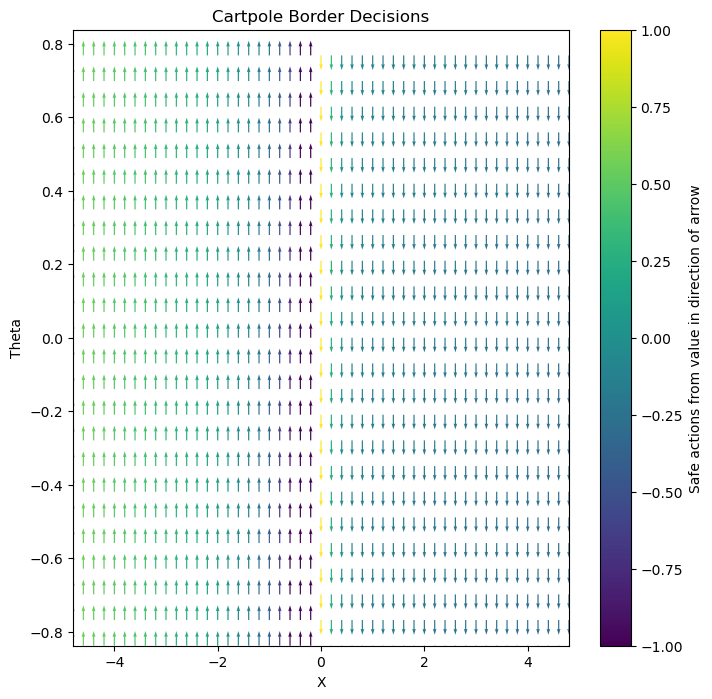

In [70]:
#Plot the hyperplanes in safe direction for all states
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
safe_radians = 24 * 2 * math.pi / 360
borders = []
arrowDirX=[]
arrowDirY=[]
safe_x=2.4
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
colors = []
for x in np.arange(-2.4-2.4,2.5+2.4,0.2):
    for theta in np.arange(-safe_radians*2,safe_radians*2,math.pi / 360 *8):
        o=[x,1,theta,1]
        a, a_h, b_h = actor3(o)
        borders.append([x,theta])
        #a_h = a_h.detach().numpy()
        #b_h = b_h.detach().numpy()
        threshold = np.clip((b_h/a_h),-1,1)
        if(a_h>0):
            to_right_is_dangerous = False
        else:
            to_right_is_dangerous = True
        if to_right_is_dangerous:
            arrowDirX.append(0)
            arrowDirY.append(-1)
            colors.append(threshold)
        else:
            arrowDirX.append(0)
            arrowDirY.append(1)
            colors.append(threshold)
borders = np.array(borders)
#rectangle = patches.Rectangle((-safe_x, -safe_radians), 2*safe_x, 2*safe_radians, linewidth=2, edgecolor='green', facecolor='white')
#ax.add_patch(rectangle)
quiver_plot=plt.quiver(borders[:,0], borders[:,1], arrowDirX, arrowDirY,colors, cmap ="viridis", angles='xy', scale_units='xy', scale=25)
# This are the borders of the simulation
plt.axis([-2*safe_x, 2*safe_x, -2*safe_radians, 2*safe_radians])
plt.colorbar(quiver_plot, label="Safe actions from value in direction of arrow")            
plt.xlabel("X")
plt.ylabel("Theta")
plt.title("Cartpole Border Decisions")
plt.show()

-3.5999999999999996
-0.6283185307179586
[1.57407499]
Box(-1.0, 1.0, (1,), float32)
[1.57407499]
[-3.6         0.         -0.62831853  0.        ]
-3.5999999999999996
-0.4886921905584123
[1.57569981]
Box(-1.0, 1.0, (1,), float32)
[1.57569981]
[-3.6         0.         -0.48869219  0.        ]
-3.5999999999999996
-0.34906585039886595
[1.57553205]
Box(-1.0, 1.0, (1,), float32)
[1.57553205]
[-3.6         0.         -0.34906585  0.        ]
-3.5999999999999996
-0.20943951023931962
[1.57621341]
Box(-1.0, 1.0, (1,), float32)
[1.57621341]
[-3.6         0.         -0.20943951  0.        ]
-3.5999999999999996
-0.06981317007977328
[1.57667187]
Box(-1.0, 1.0, (1,), float32)
[1.57667187]
[-3.6         0.         -0.06981317  0.        ]
-3.5999999999999996
0.06981317007977306
[1.57685082]
Box(-1.0, 1.0, (1,), float32)
[1.57685082]
[-3.6         0.          0.06981317  0.        ]
-3.5999999999999996
0.2094395102393194
[1.57558033]
Box(-1.0, 1.0, (1,), float32)
[1.57558033]
[-3.6         0.          

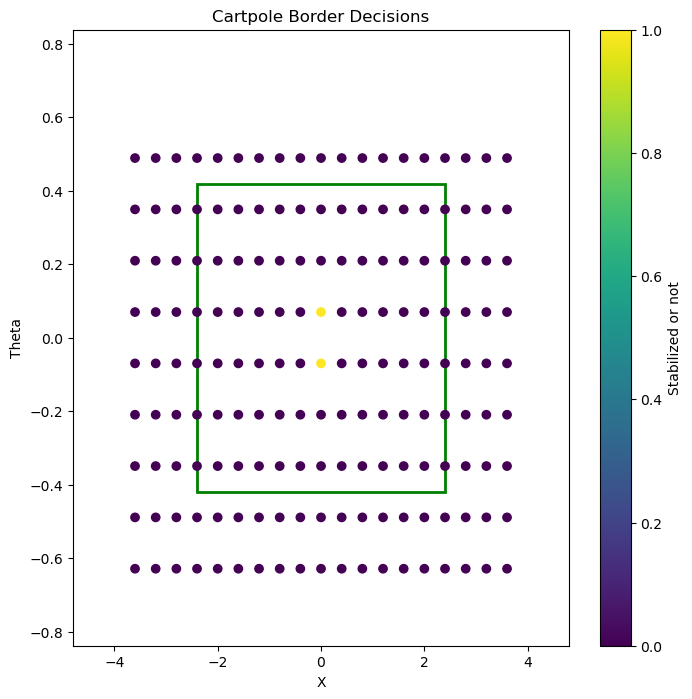

In [69]:
import time
import numpy as np
borders=[]
colors=[]
for x in np.arange(-2.4-1.2,2.5+1.2,0.4):
    for theta in np.arange(-safe_radians*1.5,safe_radians*1.5,math.pi / 360 *16):
        print(x)
        print(theta)
        o = env.reset([x,0,theta,0])
        steps = 0
        done = False
        while not done and steps <=20:
            a, a_h, b_h = actor3(o)
            #a_h = a_h.detach().numpy()
            #b_h = b_h.detach().numpy()
            a = a.reshape(-1)
            threshold = np.clip((b_h/a_h)[0],-1,1)
            next_o, r, d, info = env.step(a)
            done = d
            steps +=1
            print(a)
            print(o)
            o = next_o
        borders.append([x,theta])
        if done: 
            colors.append(0)
        else:
            colors.append(1)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
borders = np.array(borders)
safe_x = 2.4
safe_radians = 24 * 2 * math.pi / 360
rectangle = patches.Rectangle((-safe_x, -safe_radians), 2*safe_x, 2*safe_radians, linewidth=2, edgecolor='green', facecolor='white')
ax.add_patch(rectangle)
scatter_plot=plt.scatter(borders[:,0], borders[:,1],c= colors, cmap="viridis")
# This are the borders of the simulation
plt.axis([-2*safe_x, 2*safe_x, -2*safe_radians, 2*safe_radians])
plt.colorbar(scatter_plot, label="Stabilized or not")            
plt.xlabel("X")
plt.ylabel("Theta")
plt.title("Cartpole Border Decisions")
plt.show()  # Close plot to avoid replotting issues